## Import libraries

In [30]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
## For random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Import data file
Also contains one hot coded features and scaled features

In [42]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v1.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,1,1,0.0,0.0,1,0.995567,0.0,0.000000,0.891772,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,1,0.995567,0.0,0.000000,0.883542,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,0,1,0.0,1.0,0,NaN,1.0,0.301667,0.852631,...,0,0,1,0,0,0,1,0,0,0
3,certifiedembargobartender@timestudy_com,1,1,0.0,1.0,1,0.995567,0.0,0.000000,0.844384,...,0,0,0,0,1,0,1,0,0,0
4,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,0,0.995705,1.0,0.150000,0.831944,...,0,0,0,0,1,0,1,0,0,0


In [43]:
## Inspect the number of unique participant_ids
num_participants = raw_feature_df_scaled['participant_id'].nunique()
print(f"Number of unique participants: {num_participants}")

## Check the shape of the dataset
num_rows, num_cols = raw_feature_df_scaled.shape
print(f"Dataset shape: {num_rows} rows, {num_cols} columns")

Number of unique participants: 10
Dataset shape: 108075 rows, 31 columns


In [44]:
## Inspect the data typpes of all columns, except participant_id
raw_feature_df_scaled.dtypes

participant_id                object
outcome                        int64
is_weekend                     int64
in_battery_saver_mode        float64
charging_status              float64
screen_on                      int64
dist_from_home               float64
is_phone_locked              float64
last_phone_usage             float64
closeness_to_sleep_time      float64
closeness_to_wake_time       float64
mims_5min                    float64
days_in_study                float64
completion_24h               float64
completion_since_wake        float64
completion_since_start       float64
time_of_day_Afternoon          int64
time_of_day_Early Morning      int64
time_of_day_Evening            int64
time_of_day_Late Night         int64
time_of_day_Morning            int64
time_of_day_Night              int64
location_category_Home         int64
location_category_Other        int64
location_category_School       int64
location_category_Transit      int64
location_category_Work         int64
w

## Prepare test and training set
For each user, we will save the first 80% of the data in the training set, and the next 20% of the data for the test set.

In [45]:
def split_train_test_by_participant(df, id_col='participant_id', train_frac=0.5):
    """
    Splits the DataFrame into training and testing sets for each participant.
    The first train_frac (default 80%) of each participant's data goes to train, the rest to test.
    Returns: train_df, test_df
    """
    train_list = []
    test_list = []
    for pid, group in df.groupby(id_col):
        n = len(group)
        split_idx = int(np.floor(train_frac * n))
        group_sorted = group.sort_index()  # keep original order
        train_list.append(group_sorted.iloc[:split_idx])
        test_list.append(group_sorted.iloc[split_idx:])
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

# Apply the function to split the dataset
train_df, test_df = split_train_test_by_participant(raw_feature_df_scaled)
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (54034, 31)
Test set shape: (54041, 31)


### Inspect test and train dataset
We want to ensure that the % of the data split between test and train is 80-20 split

In [46]:
def participant_split_summary(train_df, test_df, id_col='participant_id'):
    """
    Returns a DataFrame with columns: participant_id, n_train, n_test, pct_train, pct_test
    """
    train_counts = train_df.groupby(id_col).size().rename('n_train')
    test_counts = test_df.groupby(id_col).size().rename('n_test')
    summary = pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)
    summary['total'] = summary['n_train'] + summary['n_test']
    summary['pct_train'] = (summary['n_train'] / summary['total'] * 100).round(2)
    summary['pct_test'] = (summary['n_test'] / summary['total'] * 100).round(2)
    summary = summary.reset_index()[[id_col, 'n_train', 'n_test', 'pct_train', 'pct_test']]
    return summary

# Example usage:
split_summary = participant_split_summary(train_df, test_df)
split_summary

,participant_id,n_train,n_test,pct_train,pct_test
0,certifiedembargobartender@timestudy_com,5777,5778,50.00,50.00
1,chewingslouchingfailing@timestudy_com,6641,6642,50.00,50.00
2,enjoyergoofinessgrudge@timestudy_com,5228,5229,50.00,50.00
3,erasuresafeguardravishing@timestudy_com,2228,2229,49.99,50.01
4,neutergoldfishsworn@timestudy_com,4362,4362,50.00,50.00
5,persevereriseswoop@timestudy_com,6496,6497,50.00,50.00
6,pretendedconstrainfraying@timestudy_com,7720,7720,50.00,50.00
7,remoldexcludingaffair@timestudy_com,3213,3213,50.00,50.00
8,slapstickporcupineslacks@timestudy_com,5718,5719,50.00,50.00
9,subtitlegrievousbazooka@timestudy_com,6651,6652,50.00,50.00


## Train RandomForest classifier
We want to classify outcome variable based on the feature vector in training and test dataset

In [47]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest_classifier(train_df, outcome_col='outcome', id_col='participant_id', random_state=42, **rf_kwargs):
    """
    Trains a RandomForestClassifier on train_df, using all columns except outcome_col and id_col as features.
    Uses class_weight='balanced' to handle class imbalance in the outcome variable.
    Returns the trained model and the feature column names.
    """
    feature_cols = [col for col in train_df.columns if col not in [outcome_col, id_col]]
    X_train = train_df[feature_cols]
    y_train = train_df[outcome_col]
    clf = RandomForestClassifier(random_state=random_state, class_weight='balanced', **rf_kwargs)
    clf.fit(X_train, y_train)
    return clf, feature_cols

# Example usage:
rf_model, feature_cols = train_random_forest_classifier(train_df)

## Test the model
We will use the remaining 20% of the data for each participant.

In [48]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def evaluate_random_forest_model(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Evaluates the RandomForest model on test_df and prints accuracy, AUC, precision, recall, and F1 scores.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}" if auc is not None else "AUC: Not available")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Example usage:
evaluate_random_forest_model(rf_model, test_df, feature_cols)

Accuracy: 0.8966
AUC: 0.8416
Precision: 0.9090
Recall: 0.9795
F1 Score: 0.9429


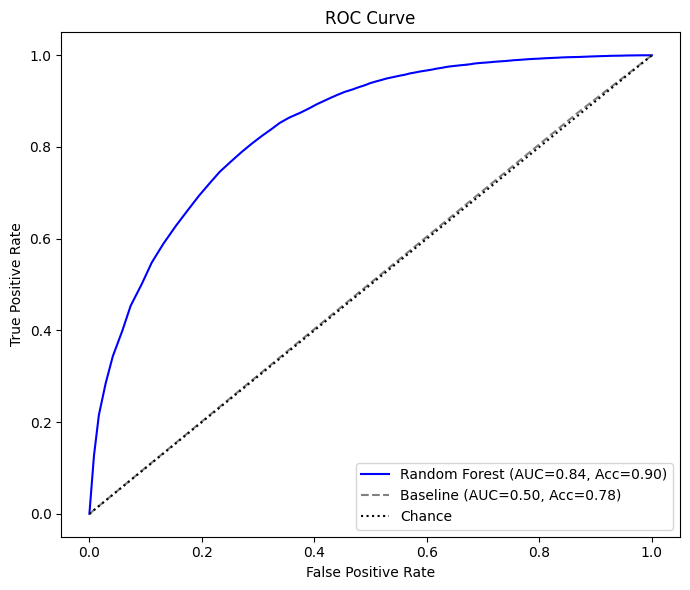

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

def plot_roc_curve_with_baseline(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Plots the ROC curve for the model and a baseline (random) classifier. Legend shows AUC and accuracy.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    if y_proba is None:
        raise ValueError('Model does not support probability prediction.')
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    # Baseline: random predictions (same positive rate as y_test)
    y_baseline = np.random.choice([0, 1], size=len(y_test), p=[1-y_test.mean(), y_test.mean()])
    fpr_base, tpr_base, _ = roc_curve(y_test, y_baseline)
    auc_base = roc_auc_score(y_test, y_baseline)
    acc_base = accuracy_score(y_test, y_baseline)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC={auc:.2f}, Acc={acc:.2f})', color='blue')
    plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={auc_base:.2f}, Acc={acc_base:.2f})', color='gray', linestyle='--')
    plt.plot([0, 1], [0, 1], 'k:', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_roc_curve_with_baseline(rf_model, test_df, feature_cols)

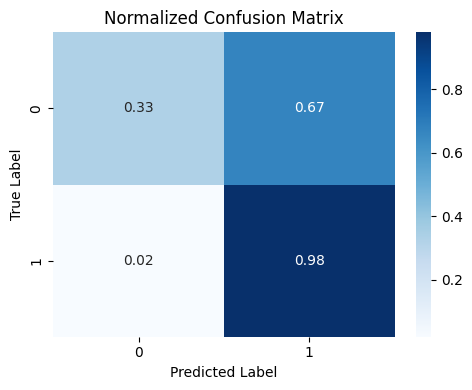

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Plots the normalized confusion matrix for predicted and ground truth labels on test_df.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_confusion_matrix(rf_model, test_df, feature_cols)

In [51]:
from sklearn.metrics import confusion_matrix

def compute_confusion_counts(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Computes and prints the counts of true positives, false positives, true negatives, and false negatives.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    return {'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn}

# Example usage:
conf_counts = compute_confusion_counts(rf_model, test_df, feature_cols)

True Positives (TP): 46181
False Positives (FP): 4621
True Negatives (TN): 2271
False Negatives (FN): 968


In [52]:

def compute_class0_metrics(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Computes and prints precision, recall, and F1 score for class 0 (negative class).
    """
    from sklearn.metrics import precision_score, recall_score, f1_score
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    print(f"Class 0 Precision: {precision_0:.4f}")
    print(f"Class 0 Recall: {recall_0:.4f}")
    print(f"Class 0 F1 Score: {f1_0:.4f}")
    return {'precision_0': precision_0, 'recall_0': recall_0, 'f1_0': f1_0}

# Example usage:
compute_class0_metrics(rf_model, test_df, feature_cols)

Class 0 Precision: 0.7011
Class 0 Recall: 0.3295
Class 0 F1 Score: 0.4483


{'precision_0': 0.701142327878975,
 'recall_0': 0.3295124782356355,
 'f1_0': 0.44832691738229197}